In [1]:
import pygeostat as gs
import gglib as gg
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
import numba
from gglib.datamgmt.simpleio import *
%matplotlib inline

In [2]:
sys.path.insert(0, 'C:/GIT/python-local/spatialcluster/')
import spatialcluster as sp
custom_style= {"savefig.dpi": 125,
               "figure.dpi": 125,
               "figure.figsize": (4, 3),
               "axes.grid": True,
               'grid.alpha': 1.0,
               'grid.color': 'black',
               'grid.linestyle': '-.',
               'grid.linewidth': 0.25,
               "axes.formatter.useoffset": False,
               "xtick.major.pad": 1,
               "ytick.major.pad": 1,
               'lines.markersize': 5}
gs.set_style("pt7", custom=custom_style)

In [3]:
variables = ['Ni', 'Fe', 'SiO2', 'MgO']

In [4]:
sys.path.insert(0, '../')
from validator import exporter as exp
exp.init_project('nilat_')

# import data

In [5]:
points = gg.PointContainer("nilat.dat")
points.info()

PointContainer: nilat.dat
Attributes:
x: 'X', y: 'Y', z: 'Z', dh: 'Hole ID'
Unused Columns:
['Ore Type', 'Ni', 'Fe', 'SiO2', 'MgO']


In [6]:
print(len(points))

6894


In [7]:
variables

['Ni', 'Fe', 'SiO2', 'MgO']

In [8]:
nstrans = gg.GaussTrans(points, variables, ltrim=-999, despike=True)
nsvars, ttbls = nstrans.forwardtrans(inplace=True)

# splitting and merging

In [9]:
stdvars = sp.columnwise_standardize(points[variables])
for i, var in enumerate(variables):
    points[f'STD_{var}'] = stdvars[:, i]
stdvariables = [f'STD_{var}' for var in variables]
nsvariables = [f'NS_{var}' for var in variables]

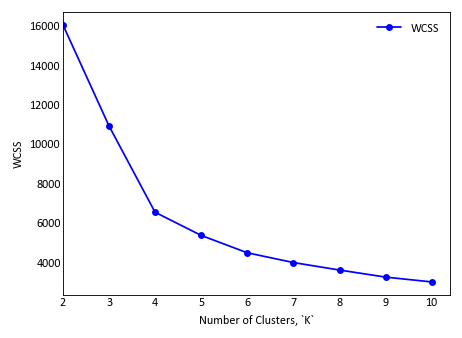

In [10]:
ax = sp.elbowplt(points, stdvariables, maxclust=10, ms=4, marker='o', lw=1)
exp.exportfigure('elbowplot.pdf')

In [11]:
nclus = 4

# mdsplotter

In [12]:
mdsvars = nsvariables + [points.x, points.y, points.z] # + variables
mdsplotter = sp.MDSPlot(points[mdsvars], rseed=10)
mdsplotter.embed(n_neighbors=5, learning_rate=0.8, repulsion_strength=0.5)

In [13]:
def genmdsplot(colors, legstr='Category', **kwargs):
    return mdsplotter.plot(colors, s=3, cmap='Spectral', 
                           legstr='Category', legend_loc='upper left', **kwargs)

# geological categories

In [14]:
catmapping = {100: 1, 200: 2, 225: 2, 250: 2, 300: 3, 350: 3, 400: 4}
points['modelcats'] = 0
for oldcat, newcat in catmapping.items():
    points.data.loc[points['Ore Type'] == oldcat, 'modelcats'] = newcat

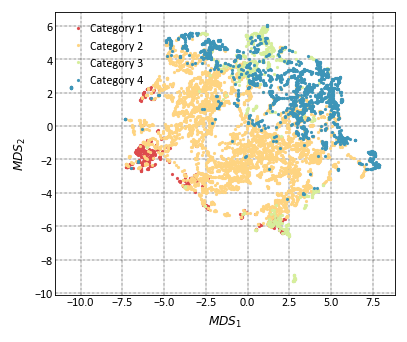

In [15]:
genmdsplot(points['modelcats'].astype(int))
exp.exportfigure('mds_modelcats.pdf')

In [16]:
[(points['modelcats'] == cat).sum() / len(points) for cat in [1, 2, 3, 4]]

[0.05932695097185959,
 0.6047287496373658,
 0.08891789962286045,
 0.24702639976791413]

# multivariate clustering

In [17]:
points['mvclus'] = sp.cluster(nclus, points[stdvariables], method='kmeans', 
                              n_init=50)[0] + 1
points['mvclus'], score = sp.reclass_clusters(points['modelcats'], points['mvclus'])
print('clustering matched with score %.5f' % score)

clustering matched with score 0.69495


In [18]:
[(points['mvclus'] == cat).sum() / len(points) for cat in [1, 2, 3, 4]]

[0.13243400058021468,
 0.38410211778357994,
 0.0667246881346098,
 0.4167391935015956]

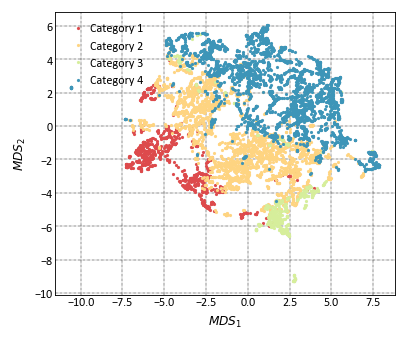

In [19]:
genmdsplot(points['mvclus'].astype(int), 'Cluster')
exp.exportfigure('mds_mvclus.pdf')

# spatial clustering 

In [20]:
points

In [21]:
ensclus = sp.DSSEnsemble(
    points[stdvariables], points.locations, nreal=1000, nnears=25, 
    numtake=4, searchparams=(50, 0, 0, 1000, 800, 15), 
    minfound=0.05, maxfound=0.75, rseed=1239
)
ensclus.fit(nclus, verbose=True, nprocesses=4)

In [22]:
points['agglom'] = ensclus.predict(nclus) + 1
points['agglom'], score = sp.reclass_clusters(points['modelcats'], points['agglom'])

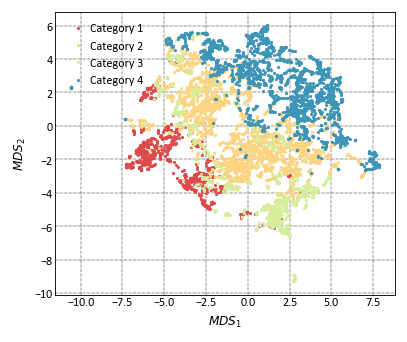

In [23]:
genmdsplot(points['agglom'].astype(int), 'Cluster')
exp.exportfigure('mds_agglom.pdf')

In [24]:
mvfunc = sp.tdiff_wcss
ensclus.computestats(mvfunc)

# better spatial clustering

In [42]:
n_clus_select = 200
newensclus = ensclus.geostat_subensemble(nclus=n_clus_select, minprop=0.05,
                                         startpt=(0.75, 0.3), endpt=(0.66, 0.41))
points['betteragglom'] = newensclus.predict(nclus) + 1
points['betteragglom'], score = sp.reclass_clusters(points['modelcats'], points['betteragglom'])

found 200 clusterings


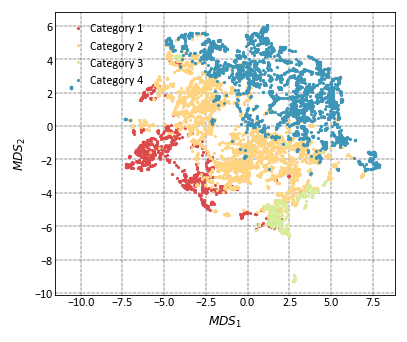

In [43]:
genmdsplot(points['betteragglom'].astype(int), 'Cluster')
exp.exportfigure('mds_betteragglom.pdf')

In [44]:
newensclus.clusterings, scores = sp.reclass_clusters(points['mvclus'], newensclus.clusterings)

# metrics

In [45]:
metrics = {}
mvm, spm = sp.cluster_metrics_single(
    points[stdvariables], points.locations, 
    np.random.randint(1, nclus + 1, len(points)), 
    ensclus.pars['nnears'], ensclus.pars['searchparams'], mvfunc
)
metrics['Random Domains'] = mvm, spm
metrics['Geological Categories'] = sp.cluster_metrics_single(
    points[stdvariables], points.locations, points['modelcats'], 
    ensclus.pars['nnears'], ensclus.pars['searchparams'], mvfunc
)

metrics['Multivariate Clusters'] = sp.cluster_metrics_single(
    points[stdvariables], points.locations, points['mvclus'], 
    ensclus.pars['nnears'], ensclus.pars['searchparams'], mvfunc
)

metrics['DS Consensus Clustering'] = sp.cluster_metrics_single(
    points[stdvariables], points.locations, points['agglom'], 
    ensclus.pars['nnears'], ensclus.pars['searchparams'], mvfunc
)

metrics['Improved DS Consensus Clustering'] = sp.cluster_metrics_single(
    points[stdvariables], points.locations, points['betteragglom'], 
    ensclus.pars['nnears'], ensclus.pars['searchparams'], mvfunc
)

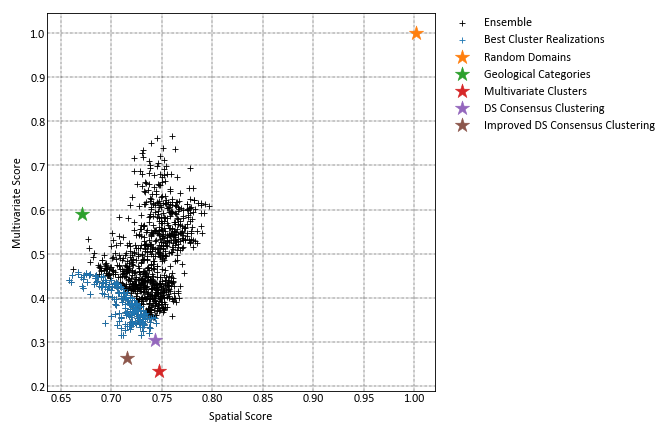

In [46]:
f, ax = plt.subplots(figsize=(4, 4))
ax.scatter(ensclus.spstat, ensclus.mvstat, c='k', marker='+', lw=0.5, s=10, 
           label='Ensemble')
ax.scatter(newensclus.spstat, newensclus.mvstat, marker='+', lw=0.5, s=10, 
           label='Best Cluster Realizations')
for name, (mvm, spm) in metrics.items():
    ax.scatter(spm, mvm, marker='*', s=75, label=name)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.02))
ax.set_xlabel('Spatial Score')
ax.set_ylabel('Multivariate Score')
exp.exportfigure('ensemble_metrics.pdf')

# finalize, writeout

In [47]:
for i in range(newensclus.clusprob.shape[1]):
    points[f'clus{i+1}prob'] = newensclus.clusprob[:, i]

iperm = np.random.permutation(n_clus_select)
for i, iclus in enumerate(iperm):
    points[f'clusreal{i}'], _ = sp.reclass_clusters_byvar(points['betteragglom'], 
                                                          newensclus.clusterings[:, iclus], 
                                                          points[stdvariables])
for i in range(newensclus.clusterings.shape[1]):
    points[f'randreal{i}'] = np.random.randint(1, nclus + 1, len(points))

In [48]:
points.writefile('nilat_maincats.dat')

In [49]:
griddef = points.infergriddef(200, 200, 50, 5)
griddef.change_blocksize(10, 10, 2)
with open('griddef', 'w') as fh:
    fh.write(str(griddef))